In [ ]:
import torch
device = torch.device('mps')

# 단순 뉴런부터 깊은 모델 만들기

### 데이터 세트 다운로드
* 딥러닝 모델 학습 과정에서 필요한 데이터 세트를 불러온다.

* 해당 데이터 세트는 날씨에 대한 정보를 담은 데이터 셋으로 네가지 클래스로 나뉘어져 있다.

* 날씨 이미지가 주어졌을 때 해당되는 클래스를 예측할 수 있다.

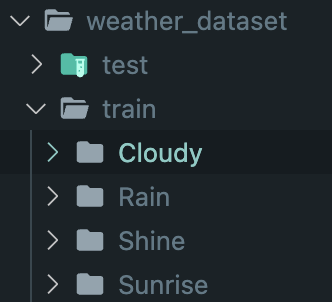

In [2]:
!git clone https://github.com/ndb796/weather_dataset
%cd weather_dataset

'weather_dataset'에 복제합니다...
remote: Enumerating objects: 1117, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 1117 (delta 0), reused 3 (delta 0), pack-reused 1111
오브젝트를 받는 중: 100% (1117/1117), 85.23 MiB | 11.54 MiB/s, 완료.
/Users/dael/Desktop/ml_study/ml-framework-study/pytorch/weather_dataset


### 라이브러리 불러오기
* 딥러닝 모델 학습 과정에서 필요한 라이브러리를 불러온다.

In [5]:
# torchvision과 하위 모듈들은 PyTorch와 연동하여 CV 태스크를 수행하기 위해 설계된 라이브러리다.
import torchvision
import torchvision.transforms as transforms # 이미지를 전처리하고 증장하는 데 사용
import torchvision.models as models # 사전 훈련된 모델(pretrained model을 제공)
import torchvision.datasets as datasets # 일반적으로 사용되는 데이터 셋을 쉽게 불러 올 수 있는 함수를 제공 (MNIST, CIFAR10 등)

import torch.optim as optim # 최적화 알고리즘을 포함 - 이를 통해 신경망의 가중치를 업데이틑하는 과정을 관리할 수 있음 (SGD, Adam 등)
import torch.nn as nn # 신경망 모델을 구성하는 데 사용되는 다양한 레이어와 함수 포함 (선형 레이어, 활성화 함수, 손실 함수)
import torch.nn.functional as F # torch.nn 모듈의 함수형 인터페이스를 제공
from torch.utils.data import random_split # torch.utils.data 모듈은 데이터 로딩과 batch처리를 위한 유틸리티 함수를 제공 
# random_split은 데이터 셋을 랜덤하게 분할하는 함수

import matplotlib.pyplot as plt # 시각화 라이브러리 - 그래프
import matplotlib.image as image # 시각화 라이브러리 - 이미지
import numpy as np # 배열을 다루는데 필요한 함수 제공. Pytorch 텐서와 호환


### 데이터 세트 불러오기
1. 데이터 증진(data augumentation)을 명시하여 초기화할 수 있다.
*  이미지를 불러올 때 어떤 방법(회전, 자르기, 뒤집기 등)을 사용할 지
2. 이후 DataLoader()를 사용하여 데이터를 불러올 수 있다.
* 어떤 데이터를 사용할지, 배치 크기, 데이터 셔플 여부를 명시할 수 있다.
* next() 함수를 사용하여 tensor 형태로 데이터를 배치 단위로 얻을 수 있다.


In [7]:
# transform_train : 이미지 데이터 훈련
transform_train = transforms.Compose([
    transforms.Resize((256, 256)), # 이미지 크기 256 * 256 픽셀로 조정
    transforms.RandomHorizontalFlip(), # 이미지 무작위 좌우 반전
    transforms.ToTensor(), # 이미지 텐서로 변환
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    ) # 텐서 정규화
])

# transform_val : 이미지 데이터 검증
transform_val = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

# transform_test : 이미지 데이터 테스트
transform_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

* 위 코드는 Pytorch의 `torchvision.transforms` 모듈을 사용해서 이미지 데이터를 전처리 하는 변환(transform) 시퀀스를 정의한다.

* 세가지 변환 시퀀스 `transform_train`, `transform_val`, `transform_test`가 각각 훈련(training), 검증(validation), 테스트(testing) 데이터셋을 위해 정의되어 있다.

* 각 변환 시퀀스는 transforms.Compose를 통해 여러 개별 변환 단계를 체이닝(chain)하여 하나의 변환 파이프라인을 구성한다. 이 파이프라인은 입력된 이미지 데이터에 순서대로 적용된다.

* 텐서의 값을 정규화 할 때 각 색상 채널(RGB)의 평균을 0.5로, 표준편차를 0.5로 조정하여 픽셀 값의 범위를 [-1,1]로 조정한다. 정규화를 통해 모델의 학습 속도를 높이고 더 빠르게 수렴하도록 한다.

* transform_val과 transform_test는 데이터 증강을 적용하지 않는다. 검증 및 테스트 과정은 일관성이 있어야 하므로, 이 데이터셋에서는 RandomHorizontalFlip과 같은 무작위 변환을 사용하지 않는다.

In [8]:
# datasets.ImageFolder : 주어진 디렉토리(root)에서 이미지를 로드하는데 사용
train_dataset = datasets.ImageFolder(
    root='train/', # 훈련 데이터가 있는 디렉토리
    transform=transform_train # 앞서 정의된 전처리 파이프라인 적용
)
data_size = len(train_dataset) # 로드된 전체 훈련 데이터셋의 크기
train_size = int(data_size * 0.8) # 데이터 셋의 80%를 훈련 데이터로 설정
valid_size = data_size - train_size # 나머지 20%는 검증 데이터로 설정

train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_size, valid_size]) # 데이터 셋을 훈련 및 검증 세트로 무작위 분할
test_dataset = datasets.ImageFolder(
    root='test/',
    transform=transform_test
)

# 훈련, 검증, 테스트 데이터셋을 위한 DataLoader 생성
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

* 위 코드는 Pytorch의 `datasets`, `torch.utils.data` 모듈을 사용하여 이미지 데이터셋을 로드하고 이를 훈련,검증,테스트 데이터셋으로 분할한 다음, 데이터 로더를 생성하는 과정을 정의한다.

* 훈련 데이터셋을 로드할 때 `shuffle=True`를 하는 이유는 데이터를 섞어 과적합을 방지하고 모델의 일반화 능력을 향상시키기 위함이다.

* 검증과 테스트 데이터셋을 로드할 때에는 데이터의 순서를 유지한다.

* 훈련 데이터와 검증 데이터를 80/20으로 분할하는 것은 일반적인 기준이며, 데이터셋의 크기, 모델, 훈련 자원에 따라 조정한다.

* 배치 크기 또한 마찬가지로 메모리 사용, 학습 속도, 모델의 성능에 따라 조정한다.

### 데이터 시각화

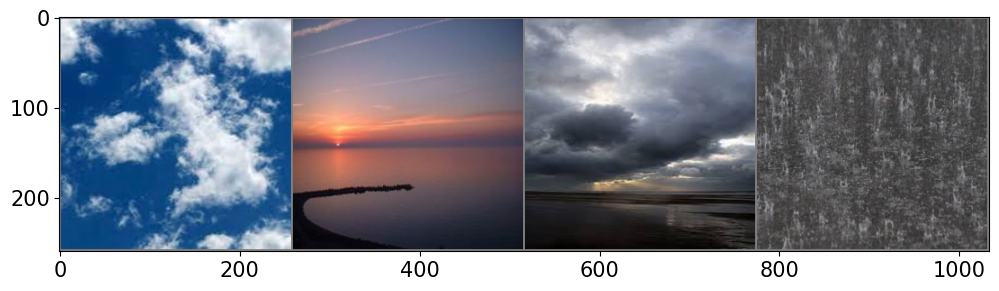

['Cloudy', 'Sunrise', 'Cloudy', 'Rain']


In [30]:
plt.rcParams['figure.figsize'] = [12, 8] # 시각화할 때 생성되는 그래프(이미지)의 크기를 설정한다. - 너비 12인치, 높이 8인치로 설정
plt.rcParams['figure.dpi'] = 100 # 해상도를 100으로 설정 - 이미지 픽셀 밀도
plt.rcParams.update({'font.size': 15}) # 폰트 크기를 15로 설정

# Pytorch 텐서 형태의 이미지를 입력받아 Numpy 텐서 형태로 변환하고 시각화 한다.
def imageShow(input):
    input = input.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    plt.imshow(input) # 변환된 이미지 배열을 화면에 표시
    plt.show() # 그림을 실제로 보여준다

# 숫자 레이블을 사람이 읽을 수 있는 이름으로 매핑
class_names = {
  0: "Cloudy",
  1: "Rain",
  2: "Shine",
  3: "Sunrise"
}

# 훈련 이미지 배치 로드
iterator = iter(train_loader)

# 훈련 이미지 배치 시각화
imgs, labels = next(iterator) # iteratr next 함수를 통해 배치 하나를 로드 - imgs : 이미지 텐서, labels : 각 이미지 레이블
print(imgs, labels)
out = torchvision.utils.make_grid(imgs[:4]) # 배치에서 첫 4개의 이미지를 grid 형태로 만든다 
imageShow(out) # 만들어진 grid를 이미지 형태로 시각화
print([class_names[labels[i].item()] for i in range(4)]) # 이미지에 대한 레이블을 매핑한 class_names를 활용해서 출력

* 위 코드는 이미지를 시각하기 위한 과정이다.

* plt.rcParams를 통해 시각화 할 때 생성되는 이미지에 대한 설정을 할 수 있다.

* imageShow 함수

    * numpy().tranpose() : PyTorch는 이미지를 `[채널(0), 높이(1), 너비(2)]`의 순서로 저장한다. transpose 함수를 사용하여 이를 `[높이(1), 너비(2), 채널(2)]`의 순서로 변경하여 matplotlib이 이해할 수 있는 형식으로 변경한다.

    * 정규화된 이미지를 원본 픽셀 값의 범위로 되돌리기 위해 정규화 과정을 역으로 다시 수행한다.
        $ \text{original\_pixel} = \text{normalized\_pixel} \times \text{std} + \text{mean} $
        <br>
        -> input = std * input + mean
        
    * 이를 통해 -1과 1사이의 값으로 정규화되었던 픽셀들이 0에서 1사이의 값으로 스케일링 되어 시각화에 적합한 형태가 된다. -> `np.clip(input, 0, 1)`